In [46]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

Distance

In [48]:
# -------------------------
# Step 1: Load Dataset
# -------------------------
df = pd.read_csv("city_remin_gemini_mmi.csv")

# -------------------------
# Step 2: Clean & Prepare Data
# Roman numeral to integer mapping for MMI scale
mmi_mapping = {
    'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5,
    'VI': 6, 'VII': 7, 'VIII': 8, 'IX': 9, 'X': 10,
    'XI': 11, 'XII': 12
}

# Apply the mapping to the MMI column
df['MMI_numeric'] = df['MMI'].map(mmi_mapping)
# -------------------------
df_clean = df[['City', 'damage_lev', 'MMI_numeric', 'Distance']].dropna()

# Clean Distance column (e.g., "295 km" → 295)
df_clean['Distance'] = (
    df_clean['Distance']
    .astype(str)
    .str.replace('km', '', case=False)
    .str.replace(',', '')
    .str.strip()
)
df_clean['Distance'] = pd.to_numeric(df_clean['Distance'], errors='coerce')
df_clean = df_clean.dropna(subset=['Distance'])



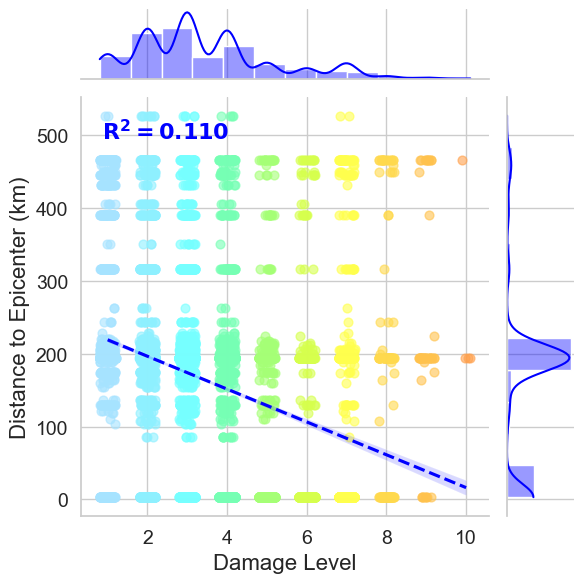

In [67]:
# -------------------------
# Step 3: Filter Cities with ≥10 Tweets
# -------------------------
city_counts = df_clean['City'].value_counts()
valid_cities = city_counts[city_counts >= 10].index
df_clean = df_clean[df_clean['City'].isin(valid_cities)].copy()

# -------------------------
# Step 4: Add MMI Category and Jitter
# -------------------------
df_clean['MMI_predicted_num'] = df_clean['damage_lev'].round().astype(int)

jitter_amount = 0.2
np.random.seed(42)
df_clean['x_jittered'] = df_clean['MMI_predicted_num'] + np.random.uniform(
    -jitter_amount, jitter_amount, size=len(df_clean)
)

# -------------------------
# Step 5: Regression (non-jittered)
# -------------------------
X_ = df_clean['MMI_predicted_num'].values.reshape(-1, 1)
y_ = df_clean['Distance'].values
model = LinearRegression().fit(X_, y_)
slope, intercept = model.coef_[0], model.intercept_
r_squared = r2_score(y_, model.predict(X_))

# -------------------------
# Step 6: Joint Plot with Style
# -------------------------
sns.set(style='whitegrid', context='notebook')
#sns.set_theme(style="darkgrid")
g = sns.JointGrid(data=df_clean, x='x_jittered', y='Distance', height=6)

# Scatter plot by MMI level color

palette = sns.color_palette("Spectral", n_colors=df_clean['MMI_predicted_num'].nunique())

mmi_colors = {
    1: "#a6e3ff",  # Light blue
    2: "#8ef0ff",  # Bright cyan
    3: "#76ffff",  # Lighter cyan
    4: "#76ffb4",  # Mint green
    5: "#a5ff76",  # Light green
    6: "#d6ff4d",  # Yellow-green
    7: "#ffff4d",  # Yellow
    8: "#ffd94d",  # Yellow-orange
    9: "#ffc24d",  # Orange
    10: "#ffa14d", # Deep orange
}

mmi_levels = sorted(df_clean['MMI_predicted_num'].unique())
for level in mmi_levels:
    subset = df_clean[df_clean['MMI_predicted_num'] == level]
    g.ax_joint.scatter(
        subset['x_jittered'],
        subset['Distance'],
        label=f"MMI {level}",
        alpha=0.6,
        s=40,
        color=mmi_colors.get(level, "gray")  # fallback to gray
    )

# Regression line
sns.regplot(
    x='MMI_predicted_num', y='Distance', data=df_clean,
    scatter=False, ax=g.ax_joint,
    color='blue',
    line_kws={'linestyle': '--'}
)

# Top marginal (histogram + KDE)
sns.histplot(df_clean['x_jittered'], ax=g.ax_marg_x, bins=12, kde=True, color='blue', alpha=0.4)


# Right marginal: histogram only (no KDE)
sns.histplot(
    data=df_clean,
    y='Distance',
    ax=g.ax_marg_y,
    bins=12, kde=True,
    color='blue',
    alpha=0.4,
    #element='bars'  # ensures classic bar look
)

# Annotate regression equation and R² 
g.ax_joint.text(
    0.05, 0.95,
    #f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_squared:.3f}$",
    f"$\\mathbf{{R^2 = {r_squared:.3f}}}$",
    transform=g.ax_joint.transAxes,
    fontsize=16,
    color='blue',
    verticalalignment='top'
)

# Final layout
g.set_axis_labels("Damage Level", "Distance to Epicenter (km)", fontsize=16)
g.ax_joint.tick_params(axis='both', labelsize=14)
g.ax_marg_x.tick_params(labelsize=12)
g.ax_marg_y.tick_params(labelsize=12)
#g.ax_joint.legend(title="MMI Level", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Input types analysis 

In [54]:
df1 = pd.read_csv("../voted/gemini_voted_model.csv")
df1 = df1[['Unnamed: 0','user_name', 'damage_level','voted']]
df_filter = df[['Unnamed__0','user_name','NAME', 'damage_lev','Distance', 'MMI_numeric']]
print(df1)
print(df_filter)

       Unnamed: 0         user_name  damage_level         voted
0               0        L MILLETTE           NaN           NaN
1               1     Brian Terbush           7.0  Text + Image
2               2       Xinzheng Lu           NaN           NaN
3               3        Elgin-Skye           NaN           NaN
4               4            Isaree           1.0  Text + Image
...           ...               ...           ...           ...
41427       41427     Gerald Farris           7.0           NaN
41428       41428          Bako.com           4.0           NaN
41429       41429  Global Analytica           3.0           NaN
41430       41430            heaven           NaN           NaN
41431       41431        Watchman ن           2.0           NaN

[41432 rows x 4 columns]
       Unnamed__0                                user_name            NAME  \
0           16532                                    David    San Fernando   
1           24146                            week 

C:\Users\missa\AppData\Local\Temp\ipykernel_34884\2585821092.py:1: DtypeWarning: Columns (21,25,26,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("../voted/gemini_voted_model.csv")


In [65]:
df_merge = pd.merge(df_filter, df1, left_on=['Unnamed__0','user_name'], right_on=['Unnamed: 0','user_name'], how = 'inner')
print(df_merge.columns)
df_merge.drop(['Unnamed__0', 'damage_lev'], axis=1, inplace=True)
df_merge['voted'] = df_merge['voted'].fillna('text only')
print(df_merge.head())
df_merge.to_csv("gemini_voted_model_merged.csv", index=False)


Index(['Unnamed__0', 'user_name', 'NAME', 'damage_lev', 'Distance',
       'MMI_numeric', 'Unnamed: 0', 'damage_level', 'voted'],
      dtype='object')
                             user_name          NAME Distance  MMI_numeric  \
0                                David  San Fernando   172 km          4.0   
1                        week old beer  San Fernando   172 km          4.0   
2                       Bruce Branstad  San Fernando   172 km          4.0   
3  Northeast Valley Health Corporation  San Fernando   172 km          4.0   
4                 Patti DiMuro Chapman  San Fernando   172 km          4.0   

   Unnamed: 0  damage_level      voted  
0       16532           3.0  text only  
1       24146           1.0  text only  
2       33270           7.0  text only  
3       37760           3.0  text only  
4       39205           3.0  text only  


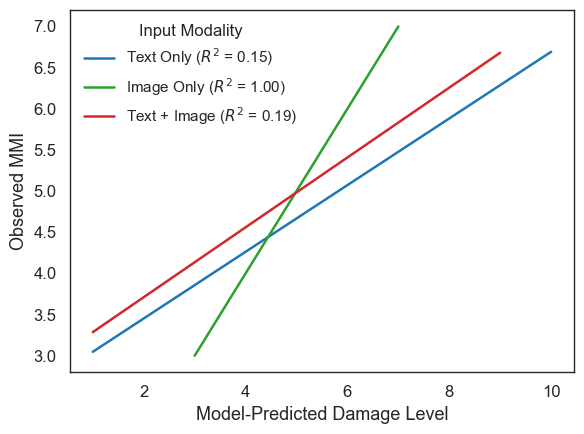

In [5]:
# reLoad dataset
df = pd.read_csv("gemini_voted_model_merged.csv")

# Normalize the voting categories
df['voted'] = df['voted'].map({
    'text only': 'Text Only',
    'Text Only': 'Text Only',
    'Image Only': 'Image Only',
    'Text + Image': 'Text + Image'
})

# Filter dataset
valid_votes = ['Text Only', 'Image Only', 'Text + Image']
df_all = df[df['voted'].isin(valid_votes)].dropna(subset=['damage_level', 'MMI_numeric'])
df_all['damage_level'] = df_all['damage_level'].astype(float)
df_all['MMI_numeric'] = df_all['MMI_numeric'].astype(float)

# Academic-style Seaborn theme
sns.set_theme(style="white", rc={
    "font.family": "serif",
    "font.serif": ["Arial", "DejaVu Serif"],
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.0,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8
})

# Soft academic palette
palette = {
    'Text Only': '#1f77b4',
    'Image Only': '#2ca02c',
    'Text + Image': '#d62728'
}

# Create figure
plt.figure(figsize=(6, 4.5))

# Draw regression lines with R² values
for group in valid_votes:
    group_df = df_all[df_all['voted'] == group]
    if len(group_df) < 2:
        continue

    X = group_df['damage_level'].values.reshape(-1, 1)
    y = group_df['MMI_numeric'].values

    model = LinearRegression().fit(X, y)
    r_squared = model.score(X, y)

    x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_vals = model.predict(x_vals)

    plt.plot(x_vals, y_vals, label=f"{group} ($R^2$ = {r_squared:.2f})", color=palette[group], linewidth=1.8)

# Axis labels
plt.xlabel("Model-Predicted Damage Level", fontsize=13)
plt.ylabel("Observed MMI", fontsize=13)

# Legend & layout
plt.legend(title="Input Modality", title_fontsize=12, fontsize=11, frameon=False, loc='upper left')
plt.tight_layout()
plt.show()
